# Convolutional Neural Net(CNN)
     
From this hands-on session on CNN you will learn how to classify natural images using a simple Convoulutional Neural Network (CNN). We have already dealt with image data from the previous hands-on sessions. However the models (Logistic Regreesion and AdaBoost) were problemetic for two reasons: 1) remember that we had to de-stucture an image first from a 2D to a 1D array so that we fit into the model definition. As a result, we loose huge amount information from flattening the image; 2) We directly used intensity features to make a prediction. However, it is often desired to have some hierarchies in a decision making process so that the intensity features are transformed into a new set of features that has deeper semantics like texture, shape etc. 

CNN solves these problems with a series of convolution kernels. The figure below illustrates how CNN solves a classfication task. Unlike Logistic Reression, CNN directly works with a 2D image witout flattening them. The raw image feature will be convolved with a small kernel to give out a newly transfored feature, where the values in the kernel are the weights we have to estimate with a loss function. Also observe that the convolved feature are again convolved to give another newly transfored feature. This iterative convolution prooss will continue unitll the transfored features are abstract enough to represent the image. The final step is to flatten them and feed to a Multinomial classification model.
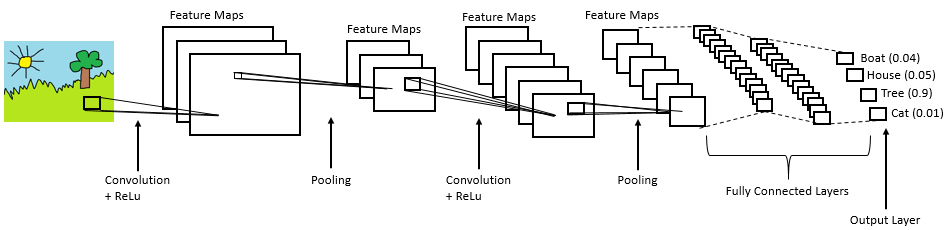

### Pytorch Code

Now lets see how trivial it is to code CNN in Pytorch. 

In [2]:
# lets first import packages we will use

from itertools import groupby

import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import functional as F
from torch.optim import Adam

from torch.utils.data import TensorDataset, DataLoader

from torchvision.datasets import CIFAR10
from torchvision import transforms

## Cifar10

We will use the CIFAR-10 dataset. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [3]:
trainD = CIFAR10(".", download = True, train = True)
testD  = CIFAR10(".", download = True, train = False)
txtLabels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


### 1. explore

number of training data : 50000 
number of testing  data : 10000 


number of images per class in training data : 
{'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}


number of images per class in testing data : 
{'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


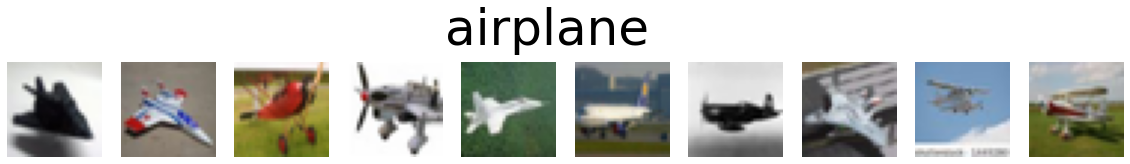

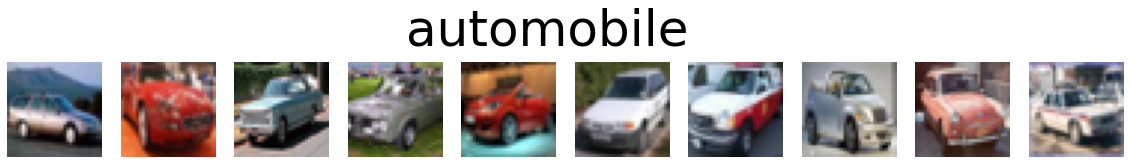

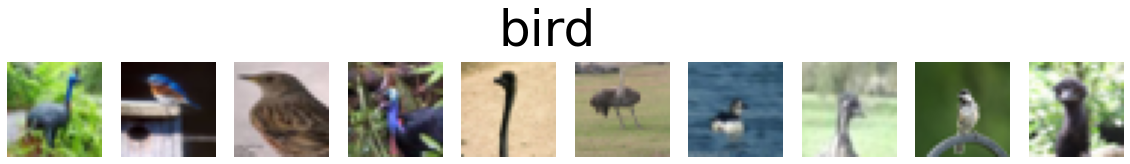

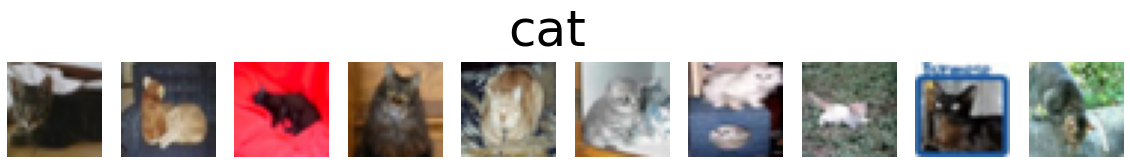

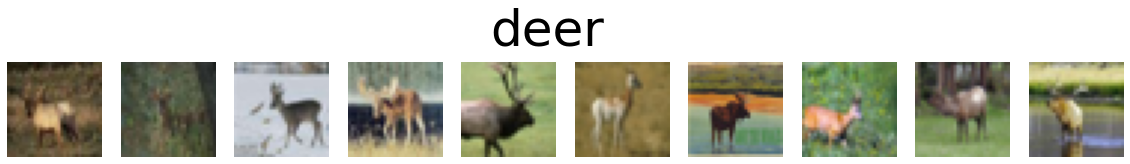

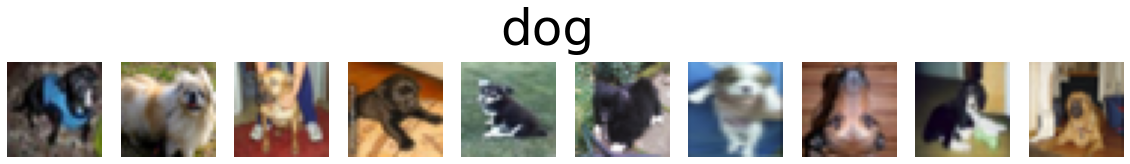

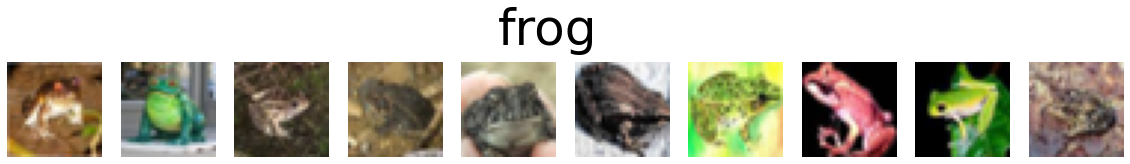

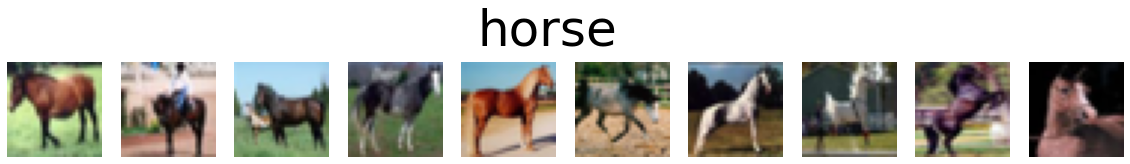

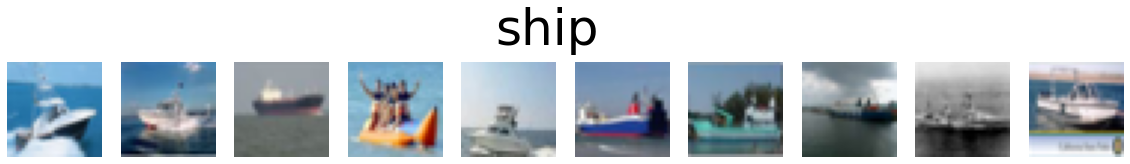

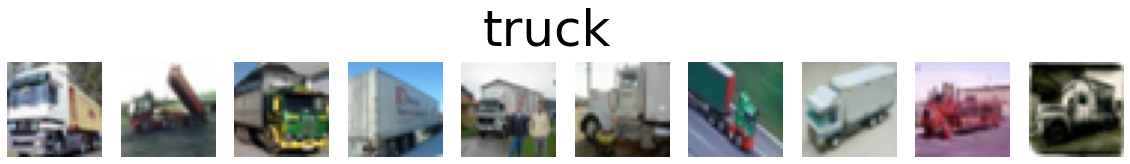

In [4]:
def showImsLabs(images, labs):
    
    byLab = lambda imglab : imglab[1]
    byImg = lambda imglab : imglab[0]
    
    imgsPerlabs = [(lab,list(map(byImg,imgs))) for lab,imgs in groupby(sorted(zip(images, np.squeeze(labs)), key = byLab), key = byLab)]
    
    for lab,imgs in imgsPerlabs:
        
        imgs = imgs[:10]
        imgN = len(imgs)
        fig, axes = plt.subplots(1,imgN, figsize = (imgN * 2, 1 * 3))

        fig.suptitle("%s" % txtLabels[lab], fontsize=50)

        for ax,img in zip(axes,imgs): 

            ax.imshow(img)
            ax.axis('off')

        plt.show()
        
        
print("number of training data : %s " % (len(trainD)))
print("number of testing  data : %s " % (len(testD)))

print("\n")
print("number of images per class in training data : ")
print(dict(zip(txtLabels,np.bincount(np.squeeze(list(zip(*trainD))[1])))))
print("\n")
print("number of images per class in testing data : ")
print(dict(zip(txtLabels,np.bincount(np.squeeze(list(zip(*testD))[1])))))

showImsLabs(*zip(*trainD))      

#### preprocess dataset

we have two preprocessing steps to be done on the dataset:

0. To tensor.tensor
    To use Pytorch APIs, we need our data to be in torch.tesor type

1. nomalization
    Same as Linear Regression, for numerical stability

In [5]:
# to tensor
toTensor = lambda pair: (transforms.ToTensor()(pair[0]), pair[1])
trainD = map(toTensor, trainD)
testD  = map(toTensor, testD)

# normalisation
normalize = lambda pair: (transforms.Normalize(mean=[0], std=[1])(pair[0]), pair[1] )
trainD = map(normalize, trainD)
testD  = map(normalize, testD)

processedTrainD = list(trainD)
processedTestD  = list(testD)

### Load as Batch

In [6]:
trainX = torch.stack(list(map(lambda pair : pair[0], processedTrainD)))
trainY = torch.tensor(list(map(lambda pair : pair[1], processedTrainD)))

trainLoader = DataLoader( TensorDataset(trainX, trainY), batch_size = 100)

testX = torch.stack(list(map(lambda pair : pair[0], processedTestD)))
testY = torch.tensor(list(map(lambda pair : pair[1], processedTestD)))

testLoader = DataLoader( TensorDataset(testX, testY), batch_size = 100)

#### Model

In [7]:
CNN = \
    nn.Sequential(nn.Conv2d(3,64,3, padding = 1),
                  nn.MaxPool2d(2,stride = 2),
                  nn.ReLU(),

                  nn.Conv2d(64,128,3, padding = 1),
                  nn.MaxPool2d(2,stride = 2),
                  nn.ReLU(),

                  nn.Conv2d(128,256,3, padding = 1),
                  nn.MaxPool2d(2,stride = 2),
                  nn.ReLU(),
                  
                  nn.Conv2d(256,512,3, padding = 1),
                  nn.ReLU(),                  
                  
                  nn.AdaptiveAvgPool2d(1),
                  nn.Flatten(),
                  
                  nn.Linear(512,512), 
                  nn.ReLU(),
                  nn.Linear(512,512), 
                  nn.ReLU(),
                  nn.Linear(512,10)).cuda()

#### Loss: Cross Entrophy

\begin{align}
J(\theta) &= -\text{log}\sum_{i=1}^{N} y_i p( y_i| x_i ; \theta )
\end{align}

In [8]:
J = torch.nn.CrossEntropyLoss()

### Optimizer

We will use Adam with momentum

In [9]:
print("configuring optimizer")
optimizer = Adam(CNN.parameters(),
                lr = 0.001)

configuring optimizer


#### Training framework

We now have all the key components of our model. lets build a training framework!

In [10]:
# initialize model
                
# train
for e in range(20):
    losses = []
    for X,y in trainLoader:
        
        X = X.type(torch.float32).cuda()
        y = y.type(torch.long).cuda()
        
        CNN.train()
        optimizer.zero_grad()
        
        yHat = CNN(X)

        loss = J(yHat,y.reshape(-1))
        losses.append(loss.item())
        loss.backward()                        
        optimizer.step()
        
    print(f"Loss at epoch:{e} = {np.mean(losses)}")    

Loss at epoch:0 = 1.715974633216858
Loss at epoch:1 = 1.225460250377655
Loss at epoch:2 = 1.0020230919122697
Loss at epoch:3 = 0.8553131829500198
Loss at epoch:4 = 0.7410286939144135
Loss at epoch:5 = 0.6447400210499763
Loss at epoch:6 = 0.5688859149813652
Loss at epoch:7 = 0.5073466404080391
Loss at epoch:8 = 0.4476557248532772
Loss at epoch:9 = 0.396474652916193
Loss at epoch:10 = 0.3528574097752571
Loss at epoch:11 = 0.3066291412562132
Loss at epoch:12 = 0.2721001363247633
Loss at epoch:13 = 0.2356965189576149
Loss at epoch:14 = 0.20747618518769742
Loss at epoch:15 = 0.16628045693039895
Loss at epoch:16 = 0.1520370006635785
Loss at epoch:17 = 0.13890358474105596
Loss at epoch:18 = 0.1266353727541864
Loss at epoch:19 = 0.10456772545538842


#### Evaluation 
Looking at the decrease in loss, it looks promising! Lets now see how it performs on a test set.

In [18]:
# test
yHats = []
ys    = []
for X,y in testLoader:

    X = X.type(torch.float32).cuda()
    y = y.type(torch.float32).cuda()
    
    CNN.eval()
    yHat = nn.functional.softmax(CNN(X), dim = 1)
    
    ys.append(y.detach().cpu().numpy())
    yHats.append(yHat.detach().cpu().numpy())
    
yHats = np.argmax(np.concatenate(yHats), axis = 1)
ys    = np.concatenate(ys).astype(int)
print("Test Accuracy:")
for i, label in zip(range(10), txtLabels) :
    
    acc = np.sum(yHats[np.where(ys == i)] == i) / sum(ys == i)*100
    acc = str(acc)[:5]
    print(f"    {label} : {acc}%")

Test Accuracy:
    airplane : 72.6%
    automobile : 90.4%
    bird : 64.4%
    cat : 42.19%
    deer : 63.4%
    dog : 61.7%
    frog : 67.10%
    horse : 85.1%
    ship : 90.10%
    truck : 86.9%


In [19]:
def plotBatch(imgBatch, labelBatch, predLabelBatch):
    
    imgs  = imgBatch[8:16]
    labs  = labelBatch[8:16].astype(int)
    preds = predLabelBatch[8:16].astype(int)
    
    fig, axes = plt.subplots(1,len(imgs), figsize = (len(imgs) * 5, 1.5 * 5))
    fig.suptitle("prediction outcome" , fontsize=50)

    for ax,img,lab,pred in zip(axes,imgs,labs,preds): 
        ax.imshow(np.transpose(img, axes = (1,2,0)))
        ax.set_title(f"true :{txtLabels[lab]}  \npredicted:{txtLabels[pred]}", fontsize=20)
        ax.axis('off')
    

    plt.show()

X     = X.detach().cpu().numpy()
y     = y.detach().cpu().numpy()
yHat  = np.argmax(yHat.detach().cpu().numpy(), axis = 1)

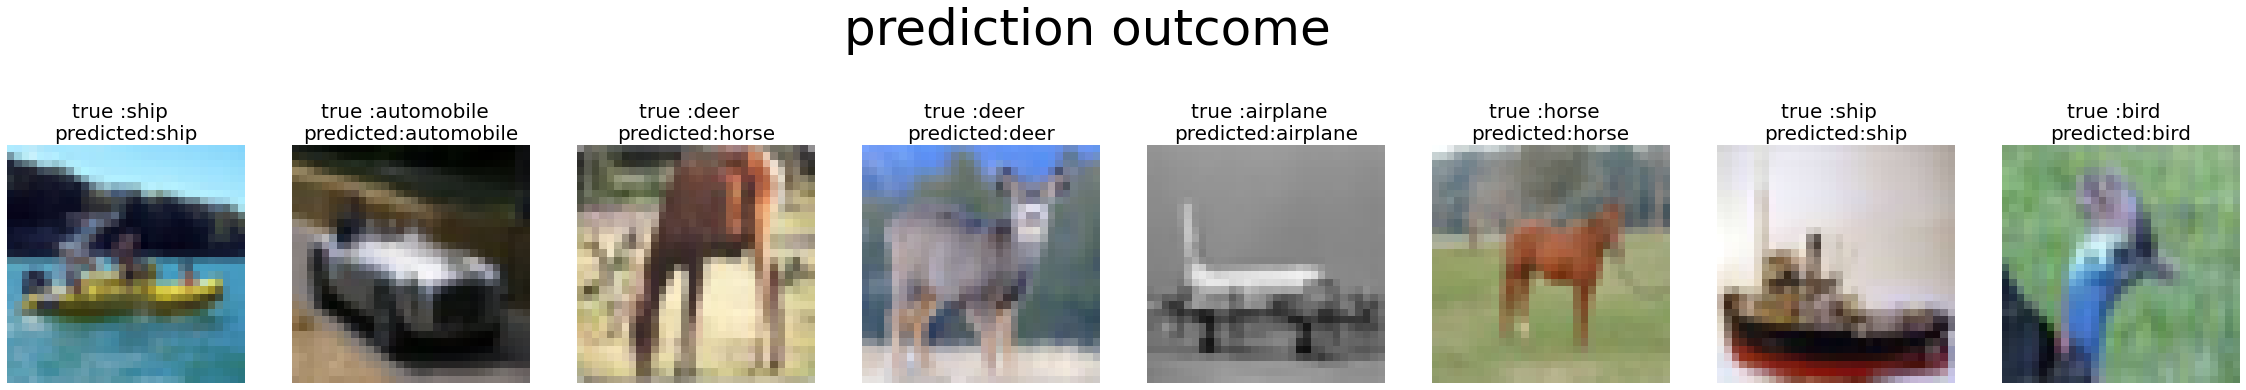

In [20]:
plotBatch(X, y, yHat)